In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import cv2
import tensorflow as tf

2025-06-03 14:08:40.212678: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748959720.467601      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748959720.535269      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/skyview-an-aerial-landscape-dataset


In [4]:
import os

dataset_path = os.path.join(path,"Aerial_Landscapes")
classes = sorted(os.listdir(dataset_path))
print("Classes found:", classes)

Classes found: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']


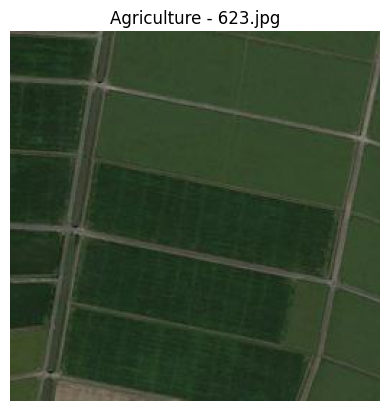

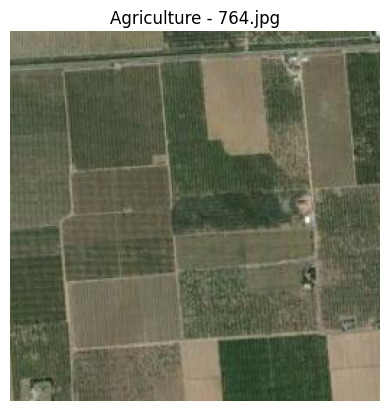

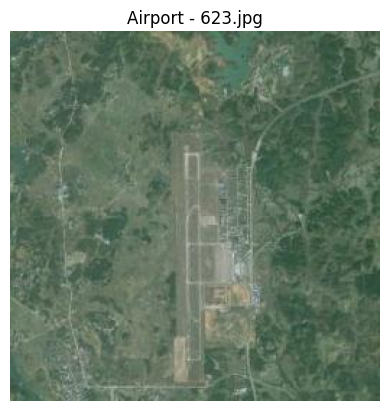

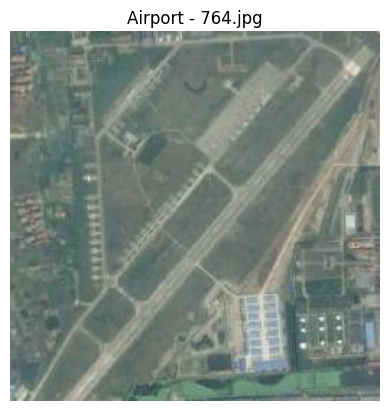

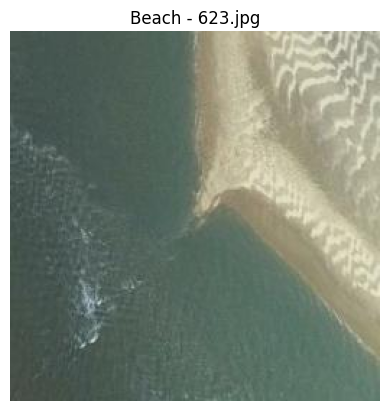

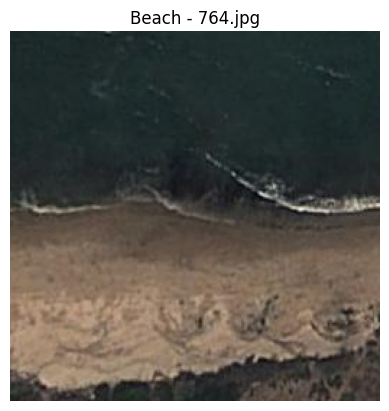

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display 2 sample images from the first 3 classes
for class_name in classes[:3]:
    class_path = os.path.join(dataset_path, class_name)
    images = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.png'))][:2]
    
    for img_file in images:
        img_path = os.path.join(class_path, img_file)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(f"{class_name} - {img_file}")
        plt.axis('off')
        plt.show()

In [ ]:
def opencv_process_image(image_tensor_uint8):
    """
    Applies noise reduction and histogram equalization using OpenCV.
    Assumes input is a 3-channel RGB uint8 NumPy array.
    """
    # Convert TensorFlow tensor to NumPy array
    img_np = image_tensor_uint8.numpy()

    # 1. Noise Reduction: Apply Gaussian Blur
    #Small kernel for mild blur.
    img_blurred = cv2.GaussianBlur(img_np, (5, 5), 0)

    # 2. Histogram Equalization
    # Convert to YCrCb color space to equalize the Y (luminance) channel
    img_ycrcb = cv2.cvtColor(img_blurred, cv2.COLOR_RGB2YCrCb)
    
    # Equalize the Y channel
    ycrcb_channels = cv2.split(img_ycrcb)
    cv2.equalizeHist(ycrcb_channels[0], ycrcb_channels[0]) # Apply to Y channel
    
    # Merge the channels back
    img_equalized_ycrcb = cv2.merge(ycrcb_channels)
    
    # Convert back to RGB
    img_processed_rgb = cv2.cvtColor(img_equalized_ycrcb, cv2.COLOR_YCrCb2RGB)
    
    return img_processed_rgb # Output is a NumPy array, uint8, RGB

# --- TensorFlow preprocessing wrapper ---
IMG_HEIGHT = 224  # Default for MobileNetV2
IMG_WIDTH = 224   # Default for MobileNetV2

def tf_preprocess_for_mobilenet(image, label):
    """
    Applies the full preprocessing pipeline for MobileNetV2.
    - Handles initial image format (e.g., from image_dataset_from_directory).
    - Applies OpenCV processing via tf.py_function.
    - Resizes the image.
    - Applies MobileNetV2 specific normalization.
    """
    # image_dataset_from_directory loads images as tf.float32 in [0, 255] range.
    # Our OpenCV function expects uint8.
    image_uint8 = tf.cast(image, tf.uint8)

    # Apply OpenCV processing using tf.py_function
    # Input to opencv_process_image is image_uint8 (a tf.uint8 tensor)
    # Output from opencv_process_image is a NumPy uint8 array, tf.py_function converts it to Tout
    processed_image = tf.py_function(
        func=opencv_process_image, 
        inp=[image_uint8], 
        Tout=tf.uint8
    )

    # Set shape for the output of py_function (it loses shape information)
    # Assuming the OpenCV function doesn't change the spatial dimensions significantly
    # before resizing. If it does, this might need adjustment or resizing within OpenCV.
    processed_image.set_shape([None, None, 3]) # Height, Width, Channels

    # Resize image to target size for MobileNetV2
    # tf.image.resize expects float input for best results and outputs float.
    image_resized = tf.image.resize(
        tf.cast(processed_image, tf.float32), 
        [IMG_HEIGHT, IMG_WIDTH]
    )
    image_resized.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])


    # Apply MobileNetV2 specific preprocessing
    # This function normalizes pixel values to the range [-1, 1].
    # It expects input as float32 in the range [0, 255].
    image_mobilenet_ready = tf.keras.applications.mobilenet_v2.preprocess_input(image_resized)
    
    return image_mobilenet_ready, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 32

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1), # Rotate by a factor of 0.1 (e.g., +/-10% of 2*pi)
    tf.keras.layers.RandomZoom(0.1),   # Zoom by a factor of 0.1 (e.g., +/-10%)
    # tf.keras.layers.RandomContrast(0.1),
    # tf.keras.layers.RandomBrightness(0.1),
])

def augment_data(image, label):
    image = data_augmentation(image, training=True) # Pass training=True to activate layers
    return image, label

#1. Load dataset (unbatched first for mapping individual images)
train_ds_unbatched = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical', # or 'categorical'
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH), # Initial load size, can be different if resizing later
    batch_size=None # Load individual images for mapping
)

val_ds_unbatched = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=None
)

Found 12000 files belonging to 15 classes.
Using 9600 files for training.
Found 12000 files belonging to 15 classes.
Using 2400 files for validation.


In [13]:
# 2. Apply the preprocessing
if 'train_ds_unbatched' in locals() and train_ds_unbatched:
    print("Preprocessing training dataset...")
    # Apply augmentations first
    train_ds = train_ds_unbatched.map(augment_data, num_parallel_calls=AUTOTUNE)
    # Then apply MobileNet specific preprocessing
    train_ds = train_ds.map(tf_preprocess_for_mobilenet, num_parallel_calls=AUTOTUNE)
    # 3. Batch and prefetch
    train_ds = train_ds.batch(BATCH_SIZE)
    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    print("Training dataset augmented, preprocessed, and batched.")
else:
    print("Skipping training dataset preprocessing (train_ds_unbatched not defined).")


if 'val_ds_unbatched' in locals() and val_ds_unbatched:
    val_ds = val_ds_unbatched.map(tf_preprocess_for_mobilenet, num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE)
    val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
    print("Validation dataset preprocessed and batched.")
else:
    print("Skipping validation dataset preprocessing example (val_ds_unbatched not defined).")


# To inspect one batch from the processed dataset:
if 'train_ds' in locals() and train_ds:
    for image_batch, label_batch in train_ds.take(1):
        print("\n--- Sample from preprocessed dataset ---")
        print("Image batch shape:", image_batch.shape) # e.g., (32, 224, 224, 3)
        print("Image batch dtype:", image_batch.dtype) # Should be tf.float32
        print("Image batch min value:", tf.reduce_min(image_batch).numpy()) # Should be around -1.0
        print("Image batch max value:", tf.reduce_max(image_batch).numpy()) # Should be around 1.0
        print("Label batch shape:", label_batch.shape) # e.g., (32,)
        break
else:
    print("Skipping dataset inspection (train_ds not defined or not processed).")

Preprocessing training dataset...
Training dataset augmented, preprocessed, and batched.
Validation dataset preprocessed and batched.

--- Sample from preprocessed dataset ---
Image batch shape: (32, 224, 224, 3)
Image batch dtype: <dtype: 'float32'>
Image batch min value: -1.0
Image batch max value: 1.0
Label batch shape: (32, 15)



--- Visualizing Data Augmentation ---


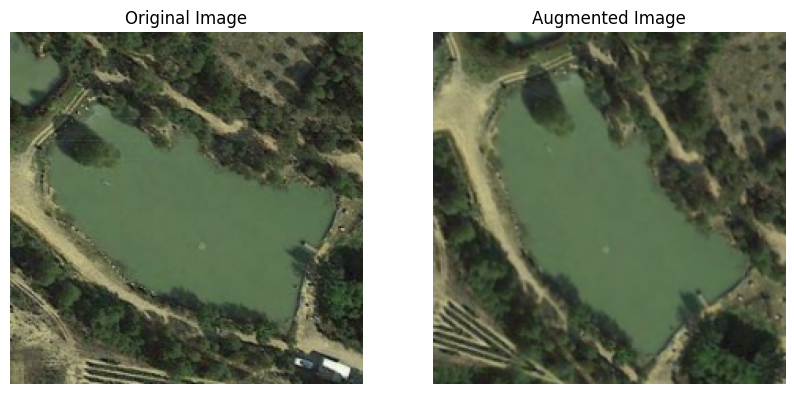

Displayed one original and its augmented version. Label (might be one-hot): [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Original image dtype: <dtype: 'float32'>, min: 2.1126086711883545, max: 254.61219787597656
Augmented image dtype: <dtype: 'float32'>, min: 7.195179462432861, max: 198.17938232421875
------------------------------


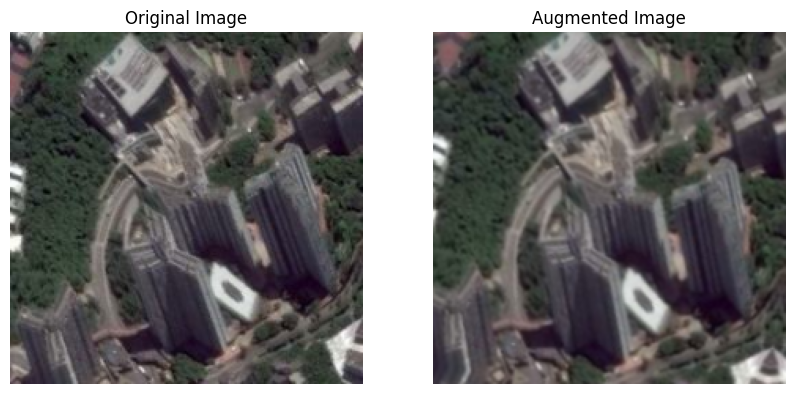

Displayed one original and its augmented version. Label (might be one-hot): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original image dtype: <dtype: 'float32'>, min: 0.0, max: 254.74490356445312
Augmented image dtype: <dtype: 'float32'>, min: 0.6601137518882751, max: 252.1278533935547
------------------------------


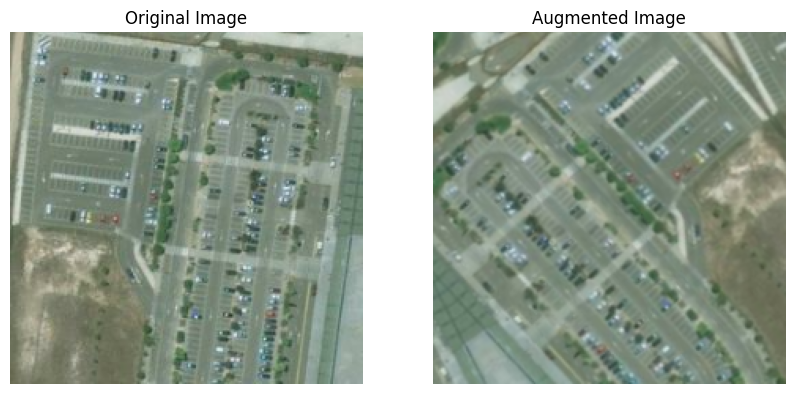

Displayed one original and its augmented version. Label (might be one-hot): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Original image dtype: <dtype: 'float32'>, min: 37.94432830810547, max: 250.75013732910156
Augmented image dtype: <dtype: 'float32'>, min: 42.87723159790039, max: 231.64231872558594
------------------------------


In [17]:
# --- Visualization Code ---
if 'train_ds_unbatched' in locals() and train_ds_unbatched and 'augment_data' in globals():
    print("\n--- Visualizing Data Augmentation ---")
    num_samples_to_visualize = 3

    for original_image, label in train_ds_unbatched.take(num_samples_to_visualize):
        # original_image is a tf.Tensor with shape (IMG_HEIGHT, IMG_WIDTH, 3)
        # and dtype tf.float32, pixels in [0, 255]

        # Apply the augmentation
        # The 'label' is passed to augment_data but not modified by it for the image
        augmented_image, _ = augment_data(original_image, label)

        plt.figure(figsize=(10, 5))

        # Display original image
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        # imshow expects floats in [0,1] or int in [0,255].
        # Since original_image is float32 [0,255], we can cast or normalize.
        # Casting to uint8 is often safer if you're unsure about exact float range.
        plt.imshow(tf.cast(original_image, tf.uint8))
        plt.axis("off")

        # Display augmented image
        plt.subplot(1, 2, 2)
        plt.title("Augmented Image")
        # augmented_image should also be float32 [0,255] (Keras layers typically preserve this)
        plt.imshow(tf.cast(augmented_image, tf.uint8))
        plt.axis("off")

        plt.show()
        print(f"Displayed one original and its augmented version. Label (might be one-hot): {label.numpy()}")
        print(f"Original image dtype: {original_image.dtype}, min: {tf.reduce_min(original_image).numpy()}, max: {tf.reduce_max(original_image).numpy()}")
        print(f"Augmented image dtype: {augmented_image.dtype}, min: {tf.reduce_min(augmented_image).numpy()}, max: {tf.reduce_max(augmented_image).numpy()}")
        print("-" * 30)

else:
    if 'train_ds_unbatched' not in locals() or not train_ds_unbatched:
        print("Skipping visualization: 'train_ds_unbatched' is not defined or empty.")
    if 'augment_data' not in globals():
        print("Skipping visualization: 'augment_data' function is not defined.")

# --- Continue with your dataset preprocessing and training pipeline ---
# (The rest of your code for .map(tf_preprocess_for_mobilenet), .batch(), .prefetch())

Found 12000 files belonging to 15 classes.
Using 9600 files for training.
Successfully loaded train_ds_unbatched.

Preparing dataset for original vs. processed comparison...
Plotting comparison...


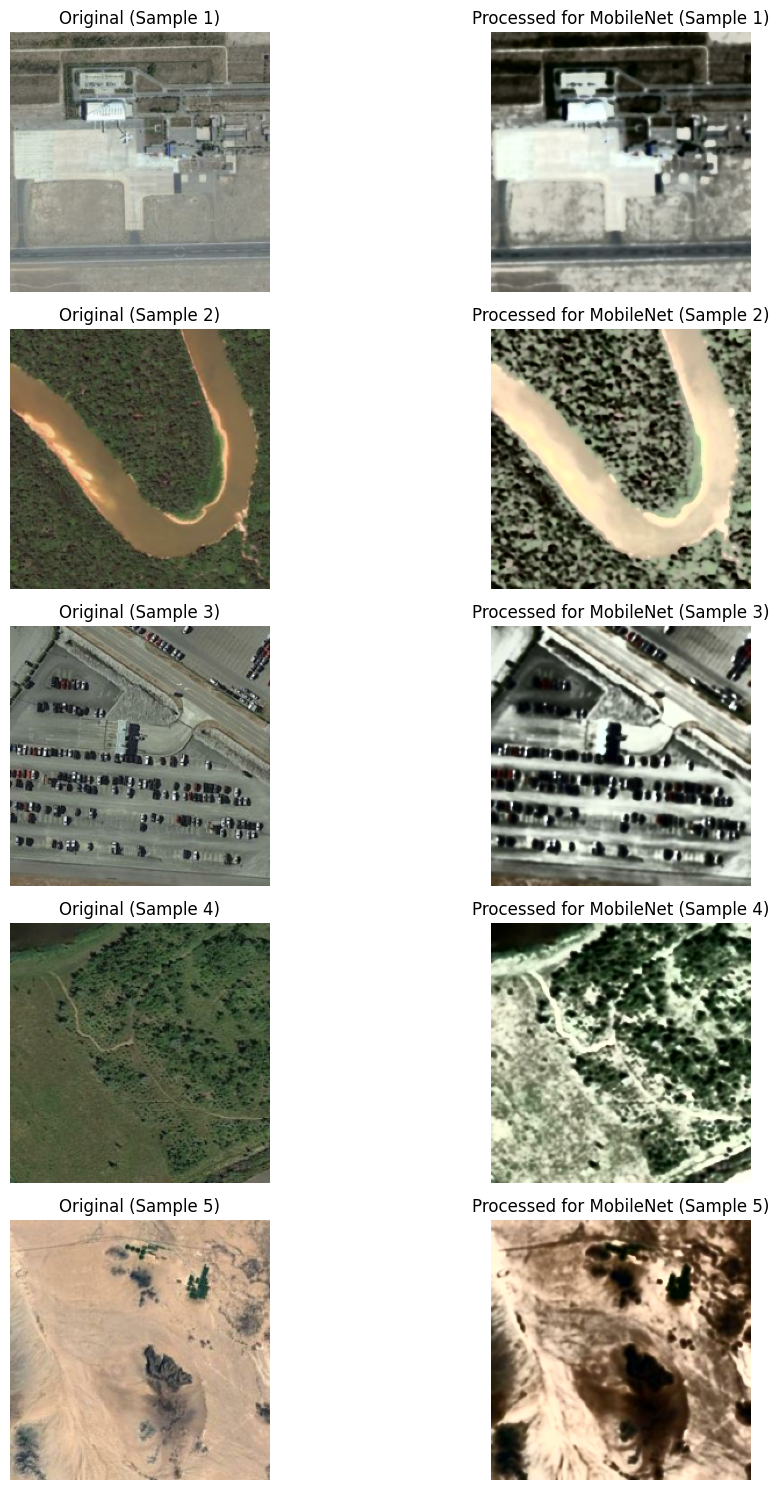

In [ ]:
try:
    train_ds_unbatched = tf.keras.utils.image_dataset_from_directory(
        dataset_path,
        labels='inferred',
        label_mode='categorical',
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=None # Load individual images for mapping
    )
    print("Successfully loaded train_ds_unbatched.")

except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please ensure 'dataset_path', 'IMG_HEIGHT', and 'IMG_WIDTH' are correctly defined.")
    train_ds_unbatched = None



# --- Visualization Code ---

def map_for_comparison_visualization(image, label):
    """
    Prepares images for side-by-side original vs. processed visualization.
    Args:
        image (tf.Tensor): Original image, typically uint8 [0-255].
        label (tf.Tensor): Label for the image.
    Returns:
        tuple: (original_display_image, processed_display_image, label)
               original_display_image is float32 [0-1]
               processed_display_image is float32 [0-1] (after denormalizing from [-1,1])
    """
    # 1. Original image for display (scaled to [0, 1])
    original_display_image = tf.cast(image, tf.float32) / 255.0

    # 2. Processed image (using your existing preprocessing function)
    # tf_preprocess_for_mobilenet is expected to return (processed_image, label)
    # where processed_image is typically in [-1, 1] for MobileNet
    processed_mobilenet_image, _ = tf_preprocess_for_mobilenet(image, label)

    # 3. Denormalize processed image from [-1, 1] to [0, 1] for consistent display
    processed_display_image = (processed_mobilenet_image + 1.0) / 2.0
    # Clip values to ensure they are strictly within [0,1] due to potential float precision
    processed_display_image = tf.clip_by_value(processed_display_image, 0.0, 1.0)


    return original_display_image, processed_display_image, label

def plot_original_vs_processed(dataset_for_viz, num_pairs=5):
    """
    Plots original and processed images side-by-side.
    Args:
        dataset_for_viz (tf.data.Dataset): A dataset yielding
                                          (original_display, processed_display, label).
        num_pairs (int): Number of image pairs to display.
    """
    if dataset_for_viz is None:
        print("Dataset for visualization is not available.")
        return

    plt.figure(figsize=(12, num_pairs * 3)) # Adjusted for better layout
    
    # Take a few samples from the visualization dataset
    for i, (original_img, processed_img, label) in enumerate(dataset_for_viz.take(num_pairs)):
        # Original Image
        plt.subplot(num_pairs, 2, 2 * i + 1)
        plt.imshow(original_img.numpy()) # Already in [0,1] float format
        plt.title(f"Original (Sample {i+1})")
        plt.axis('off')

        # Processed Image
        plt.subplot(num_pairs, 2, 2 * i + 2)
        plt.imshow(processed_img.numpy()) # Denormalized to [0,1] float format
        plt.title(f"Processed for MobileNet (Sample {i+1})")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# --- Main execution for visualization ---
if train_ds_unbatched and 'tf_preprocess_for_mobilenet' in locals():
    print("\nPreparing dataset for original vs. processed comparison...")
    # Create the comparison dataset from the unbatched training data
    comparison_viz_ds = train_ds_unbatched.map(map_for_comparison_visualization, num_parallel_calls=tf.data.AUTOTUNE if 'AUTOTUNE' in locals() else None)
    
    print("Plotting comparison...")
    plot_original_vs_processed(comparison_viz_ds, num_pairs=5)
elif not train_ds_unbatched:
    print("\nSkipping comparison visualization because 'train_ds_unbatched' could not be loaded.")
else:
    print("\nSkipping comparison visualization because 'tf_preprocess_for_mobilenet' is not defined.")
    print("Please ensure your preprocessing function is defined in the environment.")

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze for feature extraction initially
num_classes_from_shape = None
for _, label_batch_tensor in train_ds.take(1): # Take just one batch
    if hasattr(label_batch_tensor, 'shape') and len(label_batch_tensor.shape) > 1:
        num_classes_from_shape = label_batch_tensor.shape[-1] # Last dimension is the number of classes
    break 

if num_classes_from_shape is not None:
    print("Number of classes (from label batch shape):", num_classes_from_shape)
    # You would then use num_classes_from_shape for your model
    num_classes = num_classes_from_shape
else:
    print("Could not determine number of classes from label batch shape. train_ds might be empty or labels not in expected format.")

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # your number of classes
])
model.summary()

Number of classes (from label batch shape): 15


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 15)                  │           1,935 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_ds, validation_data=val_ds, epochs=30)

Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 80s 235ms/step - accuracy: 0.8285 - loss: 0.5234 - val_accuracy: 0.8746 - val_loss: 0.3702
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 68s 225ms/step - accuracy: 0.8434 - loss: 0.4992 - val_accuracy: 0.8779 - val_loss: 0.3547
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 224ms/step - accuracy: 0.8504 - loss: 0.4809 - val_accuracy: 0.8813 - val_loss: 0.3485
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 224ms/step - accuracy: 0.8464 - loss: 0.4718 - val_accuracy: 0.8813 - val_loss: 0.3431
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 224ms/step - accuracy: 0.8556 - loss: 0.4543 - val_accuracy: 0.8833 - val_loss: 0.3457
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 68s 226ms/step - accuracy: 0.8527 - loss: 0.4524 - val_accuracy: 0.8808 - val_loss: 0.3361
Epoch 7/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 68s 227ms/step - accuracy: 0.8465 - loss: 0.4542 - val_accuracy: 0.8858 - val_loss: 0.3279
Epoch 8/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 67s 225ms/step - accuracy: 0.8641 - loss: 0

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

def get_predictions(dataset):
    y_true_integers = []
    y_pred_integers = []
    
    for img_batch, label_batch_one_hot in dataset: # label_batch_one_hot is one-hot encoded
        # Convert true one-hot labels to integer format
        # label_batch_one_hot is a TensorFlow tensor, so convert to numpy first
        true_labels_for_batch = np.argmax(label_batch_one_hot.numpy(), axis=1)
        y_true_integers.extend(true_labels_for_batch)
        
        # Model prediction on the entire batch of images
        # Ensure img_batch is a tensor if model.predict expects it (usually handles numpy too)
        preds_probabilities = model.predict(img_batch) 
        
        # Get the predicted integer labels by finding the index with the highest probability
        predicted_labels_for_batch = np.argmax(preds_probabilities, axis=1)
        y_pred_integers.extend(predicted_labels_for_batch)
        
    return np.array(y_true_integers), np.array(y_pred_integers)

y_true, y_pred = get_predictions(val_ds)

if y_true.size > 0 and y_pred.size > 0:
    # Generate the classification report
    report = classification_report(y_true, y_pred)
    print(report)
else:
    print("Could not retrieve predictions or true labels. val_ds might be empty.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

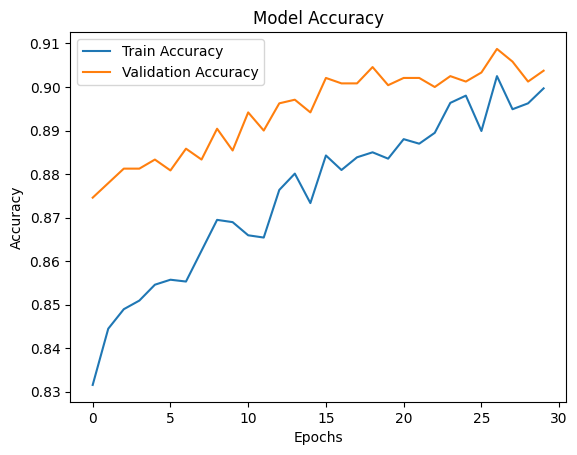

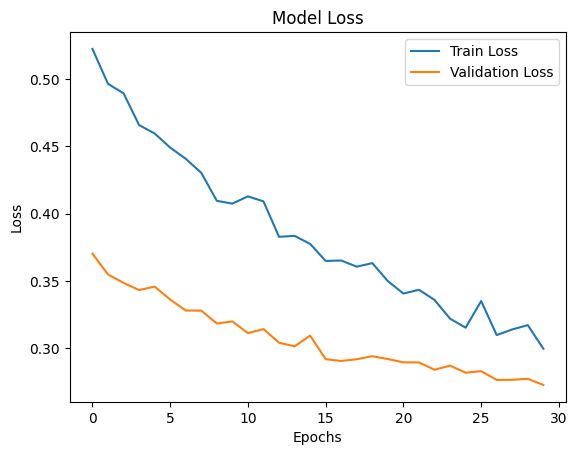

In [26]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Class names found: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


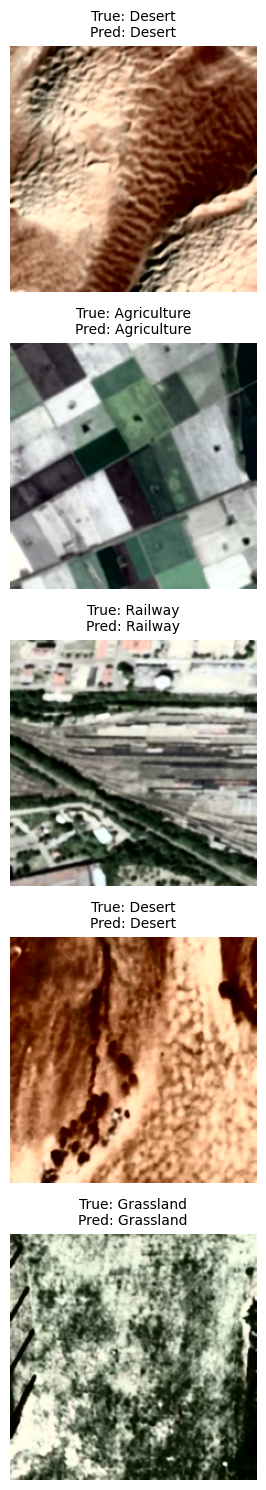

In [27]:
# class_names = train_ds.class_names

# def visualize_predictions(dataset, class_names, num_images=5):
#     plt.figure(figsize=(15, 10))
    
#     for img, label in dataset.take(1):
#         preds = model.predict(img)

#         for j in range(num_images):
#             true_label_index = label[j].numpy()
#             pred_label_index = np.argmax(preds[j], axis=-1)

#             true_label = class_names[true_label_index]
#             pred_label = class_names[pred_label_index]

#             plt.subplot(1, num_images, j + 1)
#             plt.imshow(img[j].numpy().astype("uint8"))
#             plt.title(f"True: {true_label}\nPred: {pred_label}")
#             plt.axis('off')
    
#     plt.show()

# # Visualize the predictions from the validation dataset
# visualize_predictions(val_ds,class_names, num_images=5)
def visualize_predictions(model_to_use, dataset_to_visualize, class_names_list, num_images=5):
    """
    Visualizes model predictions on a given dataset.

    Args:
        model_to_use (tf.keras.Model): The trained model.
        dataset_to_visualize (tf.data.Dataset): Dataset to get images and labels from.
                                                 Expected to yield (image_batch, label_batch_one_hot).
                                                 Images are assumed to be normalized (e.g., [-1, 1]).
        class_names_list (list): List of class names corresponding to label indices.
        num_images (int): Number of images to display from the first batch.
    """
    plt.figure(figsize=(15, 3 * num_images)) # Adjust figure size for better layout

    # Take one batch from the dataset
    for image_batch, label_batch_one_hot in dataset_to_visualize.take(1):
        # Make predictions on the batch
        predictions_probabilities = model_to_use.predict(image_batch)

        # Ensure we don't try to plot more images than available in the batch
        num_to_show = min(num_images, image_batch.shape[0])

        for j in range(num_to_show):
            # Get true label index from one-hot encoded label_batch_one_hot
            true_label_index = np.argmax(label_batch_one_hot[j].numpy()) # Corrected
            
            # Get predicted label index from probabilities
            pred_label_index = np.argmax(predictions_probabilities[j])

            # Get the string labels
            true_label_str = class_names_list[true_label_index]
            pred_label_str = class_names_list[pred_label_index]

            plt.subplot(num_to_show, 1, j + 1) # Changed subplot layout for vertical stacking if many images
            # Or for horizontal: plt.subplot(1, num_to_show, j + 1)

            # De-normalize image for display
            # Assuming images in `dataset_to_visualize` (e.g., val_ds) are normalized to [-1, 1]
            # as is typical for MobileNetV2 preprocessing.
            # If your normalization is different (e.g., [0, 1]), adjust accordingly.
            display_image = image_batch[j].numpy()
            if np.min(display_image) < -0.5: # Heuristic for [-1, 1] range
                display_image = ((display_image + 1) * 127.5).astype("uint8") # Denormalize from [-1,1] to [0,255]
            elif np.max(display_image) <= 1.0 and np.min(display_image) >=0.0: # Heuristic for [0,1] range
                 display_image = (display_image * 255).astype("uint8") # Denormalize from [0,1] to [0,255]
            else:
                display_image = display_image.astype("uint8") # Assume already in displayable range or uint8

            plt.imshow(display_image)
            plt.title(f"True: {true_label_str}\nPred: {pred_label_str}", fontsize=10)
            plt.axis('off')

    plt.tight_layout() # Adjust layout to prevent overlapping titles
    plt.show()

if hasattr(train_ds_unbatched, 'class_names'):
    class_names = train_ds_unbatched.class_names
    print(f"Class names found: {class_names}")
else:
    print("Could not find class_names attribute on train_ds_unbatched.")
    # You might need to define them manually if the attribute is not found
    # class_names = ["class0", "class1", ..., "classN"] # Replace with your actual class names


visualize_predictions(model, val_ds, class_names, num_images=5) # You can change num_images


In [ ]:
model.save('model2.h5')